# Component wise Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
data = pd.read_excel(r'Consumption dataset.xlsx')
data.columns = ['Temp', 'Vaccum', 'Pressure', 'Humidity', 'Energy_Output']

Features consist of hourly average ambient variables 
- Temperature  in the range 1.81°C and 37.11°C,
- Pressure  in the range 992.89-1033.30 milibar,
- Humidity in the range 25.56% to 100.16%
- Vacuum in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output 420.26-495.76 MW


In [2]:
data

,Temp,Vaccum,Pressure,Humidity,Energy_Output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [3]:
data.describe()

,Temp,Vaccum,Pressure,Humidity,Energy_Output
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


## In this exercise we will be deploying Decision tree model using Component wise gradient boosting algorithm to predict the Energy output uisng above dataset.

### Working of Gradient Boosting algorithm

- Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor.

- This method tries to fit a new decision tree using the independent variables to predict the residual errors made by the previous predictor.

- The prediction for new data is calculated by summing up the offset value and predictions made by all the trees which are factored down by learning rate in order to avoid overfitting.

### Component wise Gradient boosting Algorthim

- This algorithm also follows the same process but with a minor tweak. While fitting a single new decision tree in order to predict the residual errors, we first fit multiple decision trees using fixed subset of independent variables and then select the one having least sum of squared residuals.

- The tree with the lowest sum of squared residuals (SSR)is used in making the prediction.

- Likewise we sequentially add up the trees by the above process and for the final prediction we sum up the offset value and the predictions made by the subsequent trees ( ones selected having least SSR ) factored by learning rate to avoid overfitting.

### Cost Function and The negative gradient

- As this is a regression task we are using the squared error lost function $l(y_t, \eta) = 1/2(\eta - y_t)^2$

- The negative gradient for this cost function = $ y_t - \eta $, the residual

In [4]:
data_X = data.loc[:,('Temp','Vaccum','Pressure','Humidity')]
data_Y = data.loc[:,('Energy_Output')]


In [5]:
from sklearn.tree import DecisionTreeRegressor
alpha = 0.4  # Learning Rate

# Step 1: Step 1: We initialize a leaf node with an offset value. The leaf node is set to be the mean of 
#the Energy_output. This means that for every instance the prediction is mean of the data.
eta_0 = data_Y.mean()



# Step 2: Compute the negative gradient 
y_hat = np.array([eta_0]*len(data_Y))


def squared_error(y, eta):                
    return ((eta - y)**2) 

def negative_gradient(y, eta):
    return y - eta

residuals = negative_gradient(data_Y, y_hat)



# Step 3: Fit Multiple Decision trees with fixed subset of predictors to the residual from previous step
subset = [data_X['Temp'], data_X['Vaccum'], data_X['Pressure'], data_X['Humidity']]


#Depth = 1, as we want one crtical value to compare if the new instance is above or below the threshold to compare 
regressor_tree = DecisionTreeRegressor(max_depth =1)     

#Repeat steps 2, 3, 4 of the algorithm till convergence

for i in range(1000):
    
    SSR = []
    # We fit decision trees for subset of individual predictor and choose the tree with smallest SSR
    for predictor in subset:
        regressor_tree.fit((np.array(predictor)).reshape(-1,1), residuals)
        res = residuals - regressor_tree.predict((np.array(predictor)).reshape(-1,1))
        SSR.append((res**2).sum())
    
    
    # Fitting Decision tree with lowest sum of squared residuals to update the prediction
    #print(SSR)
    sub_pos = SSR.index(min(SSR))
    regressor_tree.fit(np.array(subset[sub_pos]).reshape(-1,1), residuals)
    prediction = regressor_tree.predict(np.array(subset[sub_pos]).reshape(-1,1))
    residuals = negative_gradient(residuals, prediction)
    y_hat = y_hat + alpha * prediction
    print(sub_pos, '----->',  (sum((data_Y - y_hat)**2)/9568))


    


0 -----> 156.85346405967618
1 -----> 133.81971038999262
0 -----> 118.97330532241172
0 -----> 138.89880350301613
0 -----> 124.40512101695305
0 -----> 115.1734348234998
0 -----> 129.74702374543006
0 -----> 119.88723766565978
0 -----> 127.03104633772034
0 -----> 118.10072428905707
0 -----> 124.6805852317675
1 -----> 116.78346024911427
0 -----> 123.08041660969624
1 -----> 117.9344520216139
3 -----> 119.78519062171098
2 -----> 117.96377904311996
1 -----> 121.7018575278512
0 -----> 118.49148925420805
0 -----> 116.87125445257651
0 -----> 120.68380215781832
0 -----> 115.98889357792602
1 -----> 119.05610826930673
1 -----> 115.76983270600824
0 -----> 120.02919376808168
0 -----> 116.16968595576334
0 -----> 118.88945873378057
3 -----> 119.72671149510306
0 -----> 116.89272676525091
0 -----> 119.53178839587063
0 -----> 116.11758397645394
0 -----> 118.90232633777339
1 -----> 116.68755142048737
1 -----> 117.159915183022
0 -----> 116.35188390236576
3 -----> 117.26251920946447
0 -----> 116.8622389158185

1 -----> 115.09552643479886
1 -----> 114.74224459997677
1 -----> 115.1174238767154
1 -----> 114.71912073346954
1 -----> 115.08416258086595
1 -----> 114.73525683520222
1 -----> 115.05453904248984
1 -----> 114.74375188226607
1 -----> 115.04218567755989
2 -----> 114.79365812935121
0 -----> 114.82987368401227
0 -----> 114.79437789803177
0 -----> 114.81825822398811
0 -----> 114.86070031232343
0 -----> 114.75263568812345
0 -----> 114.98417173606337
3 -----> 114.7917181259472
3 -----> 114.96256288547697
0 -----> 114.64780822910518
0 -----> 115.07264146765084
0 -----> 114.65510489117793
0 -----> 115.00004762144971
3 -----> 114.8776351331006
3 -----> 115.02287570435891
0 -----> 114.68223720975634
0 -----> 114.90946118336304
3 -----> 114.75495584468085
3 -----> 114.90317160295857
0 -----> 114.73674917099167
0 -----> 114.72009731702722
0 -----> 114.95417725167385
0 -----> 114.66854164118845
0 -----> 114.94468158726919
1 -----> 114.83461053361609
1 -----> 114.98470300141965
1 -----> 114.7343091983

1 -----> 114.51983438011585
1 -----> 114.31456757730454
1 -----> 114.52433717018573
1 -----> 114.31580347067403
1 -----> 114.46301451886161
1 -----> 114.30606102537682
1 -----> 114.51042494546563
1 -----> 114.31332388784232
1 -----> 114.52125780117417
1 -----> 114.32002971706069
1 -----> 114.48025494143681
1 -----> 114.32033786576443
1 -----> 114.50479943199943
2 -----> 114.41234619718044
2 -----> 114.50857666418614
1 -----> 114.32838761026703
1 -----> 114.49015269059917
1 -----> 114.33508625632558
1 -----> 114.49647772525014
2 -----> 114.40734469874619
1 -----> 114.35837264605912
0 -----> 114.40542609717362
3 -----> 114.33490501043838
3 -----> 114.40998533936097
3 -----> 114.34174190414646
2 -----> 114.4335797528166
2 -----> 114.41074470304486
2 -----> 114.44502953746391
2 -----> 114.39133771477618
3 -----> 114.44663502957485
3 -----> 114.39545405870497
3 -----> 114.4351811708697
3 -----> 114.3995267387427
1 -----> 114.25134509906344
0 -----> 114.56429474479975
0 -----> 114.2042344794

1 -----> 114.03046430121277
1 -----> 114.29736863976059
1 -----> 113.99780975456227
0 -----> 114.29537192034024
0 -----> 113.99439074677126
1 -----> 114.25215815278588
1 -----> 113.99898011489537
1 -----> 114.26952987387385
1 -----> 114.04239496361717
1 -----> 114.27151012984004
1 -----> 113.99880502971556
1 -----> 114.26159668698541
1 -----> 113.99868880729895
1 -----> 114.25027403086668
1 -----> 113.99968712802611
1 -----> 114.25857036057701
1 -----> 114.03437351916783
1 -----> 114.2531670498475
1 -----> 114.03393456224576
1 -----> 114.25693441875107
1 -----> 113.99988930411288
1 -----> 114.2430775375498
1 -----> 113.99348317193284
1 -----> 114.23715307920752
1 -----> 114.02389858201592
1 -----> 114.24108089268334
1 -----> 113.99610392521132
1 -----> 114.22875643287928
1 -----> 113.98588592777975
1 -----> 114.2370130075465
1 -----> 113.96307038163161
0 -----> 114.2465880933487
0 -----> 113.95017933639771
0 -----> 114.23740043508646
0 -----> 113.95924191327467
1 -----> 114.22287360234

### From the above output we can see, the MSE decreases as the number of trees are being sequentially added. ALso, we can see the change in selection while fitting the decision tree with lowest SSR, where Vaccum being used the most (1)

In [6]:
result = [data_Y,y_hat]
result = pd.DataFrame(result)
result = result.T
result.rename(columns = {'Energy_Output':'Observed', 'Unnamed 0':'Predicted'})

,Observed,Predicted
0,463.26,458.149925
1,444.37,450.173351
2,488.56,467.236769
3,446.48,452.091755
4,473.90,461.253901
...,...,...
9563,460.03,456.033682
9564,469.62,461.662075
9565,429.57,446.266625
9566,435.74,448.774076


### Visualization

In [7]:
import matplotlib.pyplot as plt

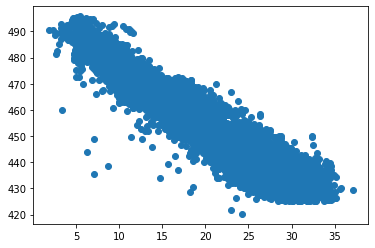

In [8]:
plt.scatter(data_X['Temp'], data_Y)

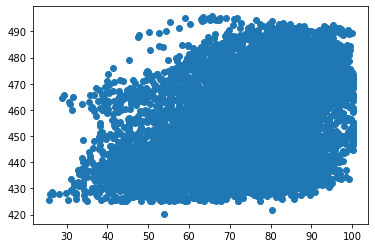

In [9]:
plt.scatter(data_X['Humidity'], data_Y)

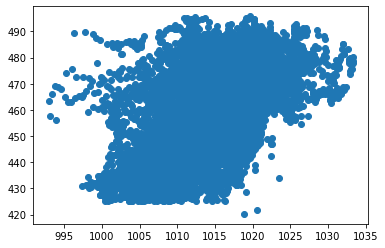

In [10]:
plt.scatter(data_X['Pressure'], data_Y)

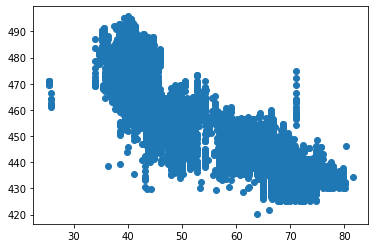

In [11]:
plt.scatter(data_X['Vaccum'], data_Y)